In [16]:
import pandas as pd

wide_data = pd.read_csv('wide1.csv')
wide_data.head()

,SUBJECT_ID,drug_217_1,condition_1922_1,condition_785_1,drug_49_1,measurement_132_1,condition_1561_1,observation_182_1,condition_2391_1,condition_175_1,...,measurement_343_3,measurement_658_3,measurement_725_3,measurement_1159_3,measurement_870_3,measurement_71_3,measurement_1066_3,measurement_923_3,measurement_1081_3,measurement_15_3
0,1,0.0,0.000778,0.004665,0.005623,0.010544,0.010651,0.010820,0.012317,0.032821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.800448,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


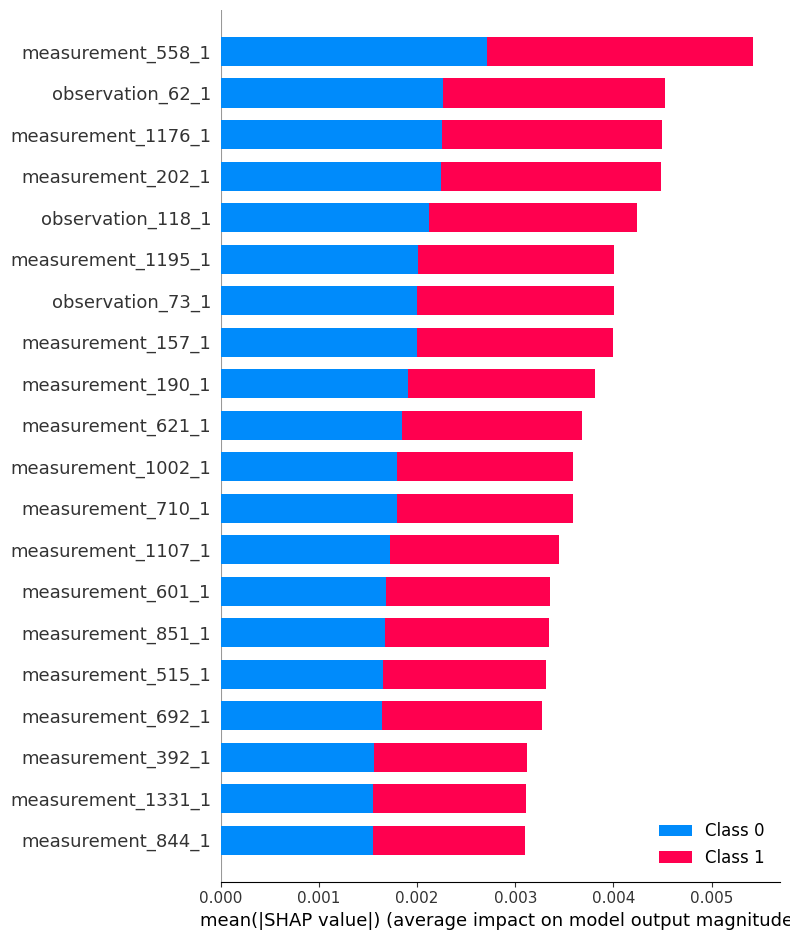

In [17]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

features = wide_data.drop(columns=['death', 'SUBJECT_ID'], axis=1)
labels = wide_data['death']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(criterion= 'entropy', max_depth= 30, n_estimators= 1000)
model.fit(X_train_smote, y_train_smote)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

In [18]:
import numpy as np

shap_sum = np.abs(shap_values[1]).mean(axis=0)
importance_df = pd.DataFrame([X_train.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['Feature', 'SHAP Importance']
importance_df = importance_df.sort_values('SHAP Importance', ascending=False)

print(importance_df)

                 Feature SHAP Importance
1981   measurement_558_1        0.002713
275     observation_62_1        0.002264
1153  measurement_1176_1        0.002249
2682   measurement_202_1        0.002241
3303   observation_118_1        0.002118
...                  ...             ...
6311    observation_23_3             0.0
6312   observation_126_3             0.0
6313          drug_163_2             0.0
6314   observation_156_3             0.0
8689    measurement_15_3             0.0

[8690 rows x 2 columns]


In [19]:
features_to_keep = importance_df[importance_df['SHAP Importance'] > 0]['Feature']
updated_wide_data = wide_data[features_to_keep.tolist() + ['death']]
updated_wide_data.shape

(727, 5234)

ROC AUC Score: 0.7855046285843306


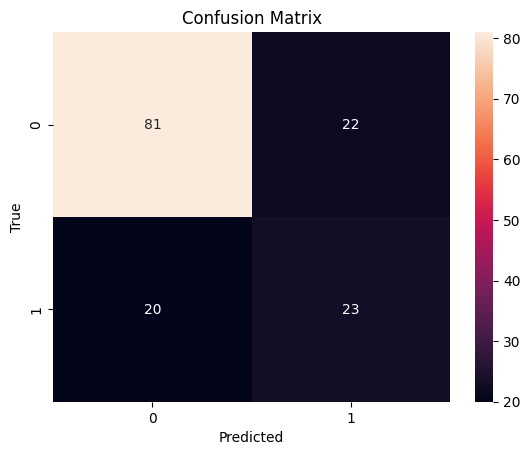

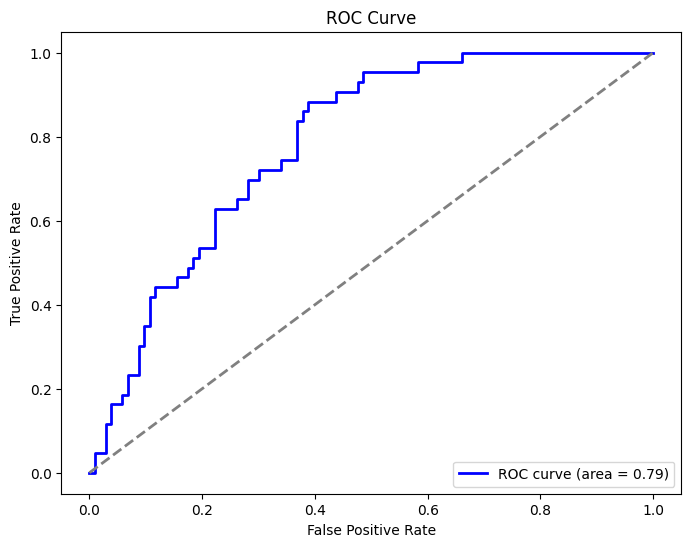

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

features = updated_wide_data.drop(columns=['death'], axis=1)
labels = updated_wide_data['death']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42, criterion= 'entropy', max_depth= 30, n_estimators= 1000)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
max_shap_importance = np.max(importance_df['SHAP Importance'])

threshold = 0.15 * max_shap_importance

features_to_keep = importance_df[importance_df['SHAP Importance'] > threshold]['Feature']

updated_wide_data = wide_data[features_to_keep.tolist() + ['death']]

updated_wide_data.shape

(727, 370)

ROC AUC Score: 0.7931813050349966


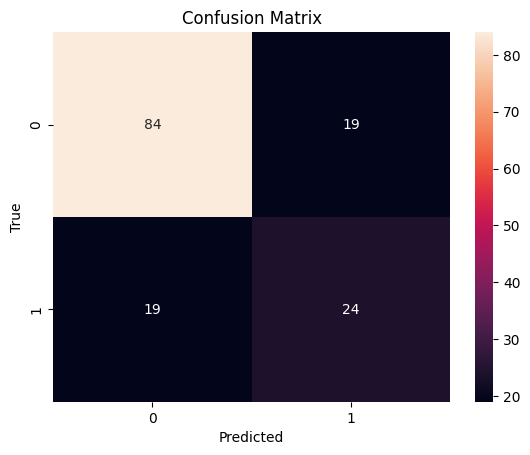

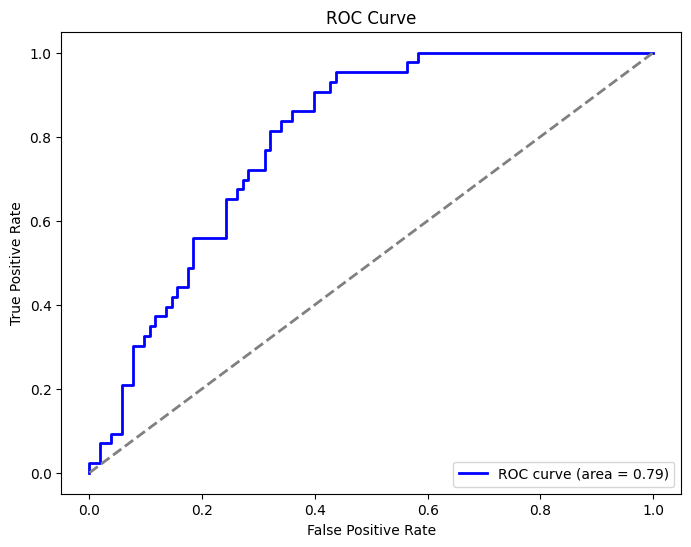

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

features = updated_wide_data.drop(columns=['death'], axis=1)
labels = updated_wide_data['death']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42, criterion= 'entropy', max_depth= 30, n_estimators= 1000)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()